In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    return tp / (tp + fn)

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    if tn == 0 and fp == 0: return 1.0
    return tn / (tn + fp)

# def balanced_acc(sensitivity, specificity):
#     return (sensitivity + specificity) / 2.0

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=True)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (154, 224, 224)
X_test shape: (66, 224, 224)
y_train shape (154,)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

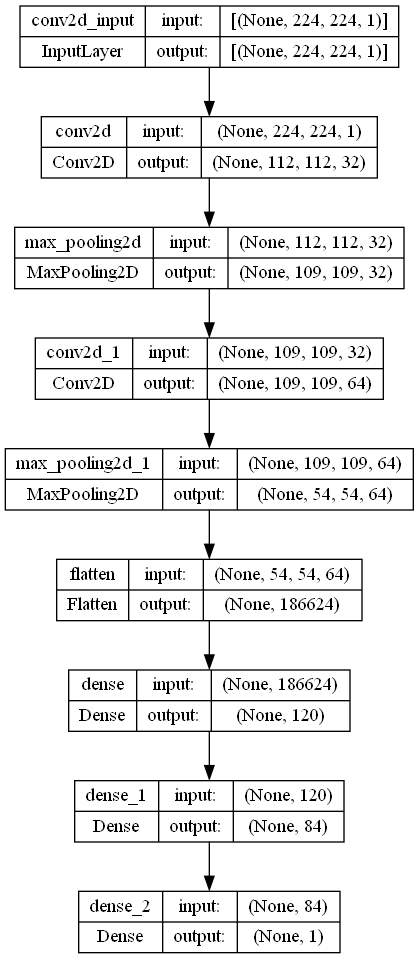

In [4]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

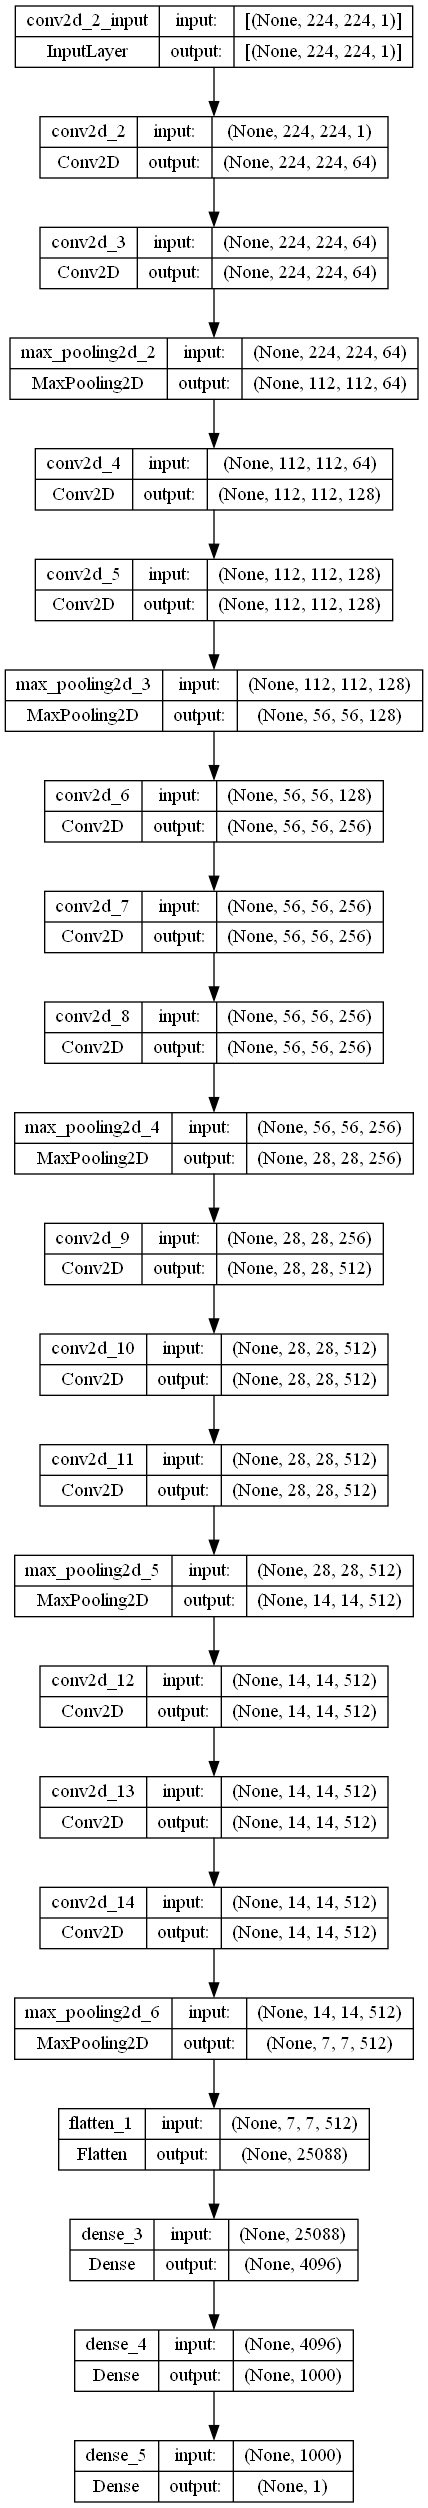

In [5]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

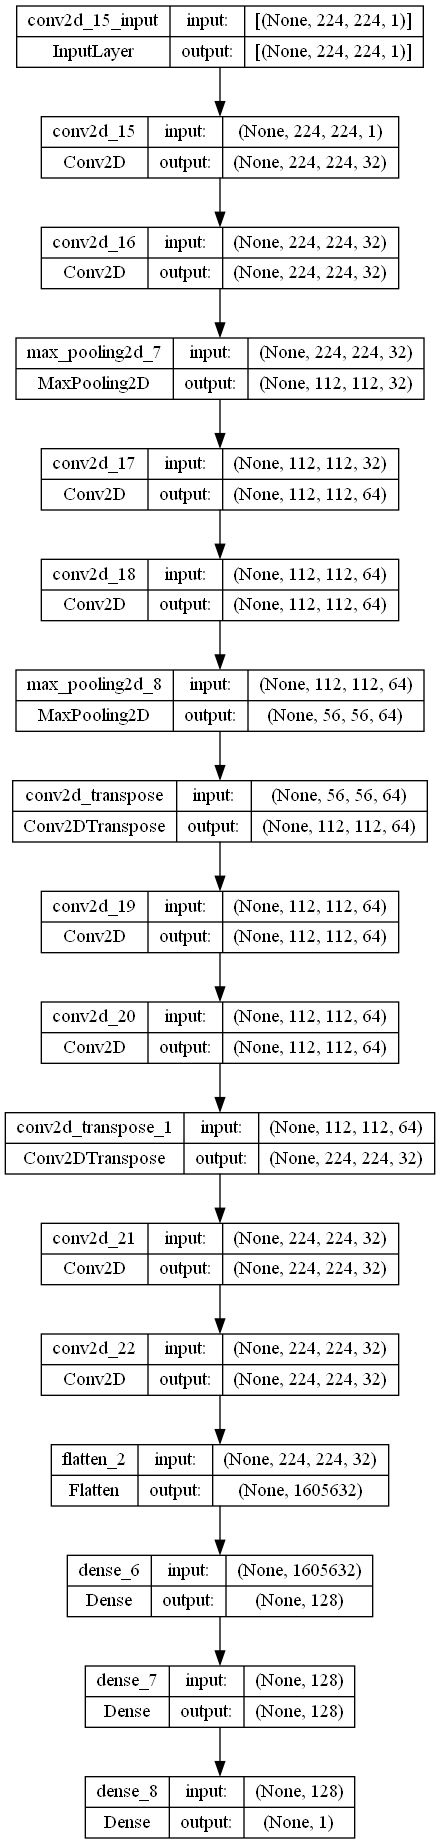

In [6]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [7]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    sensitivity,
    specificity,
    balanced_acc
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [9]:
# le_net_5_k = KerasClassifier(le_net_5, epochs=100, batch_size=20, verbose=2)
# vgg_16_k = KerasClassifier(vgg_16, epochs=100, batch_size=20, verbose=2)
# lu_net_k = KerasClassifier(lu_net, epochs=100, batch_size=20, verbose=2)

# sd = seed(time())
# RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=sd)

In [8]:
def fit_evaluate(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=100, validation_split=0.2):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    scores_model =model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics):
    fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
    for i, metric in zip(range(len(metrics)), metrics):
        ax[i].plot(range(1, 101), df[metric], 'b-', label='Train')
        ax[i].plot(range(1, 101), df[f'val_{metric}'], 'r-', label='Validation')
        ax[i].set_title(metric)
        ax[i].legend()
    plt.show()

In [10]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

Epoch 1/100


c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 8s 2s/step - loss: 159.5756 - precision: 0.6271 - binary_accuracy: 0.5447 - recall: 0.5211 - sensitivity: 0.5000 - specificity: 0.5000 - balanced_acc: 0.5000 - val_loss: 24.6367 - val_precision: 0.7419 - val_binary_accuracy: 0.7419 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 11.8673 - precision: 0.5929 - binary_accuracy: 0.5935 - recall: 0.9437 - sensitivity: 0.9333 - specificity: 0.1250 - balanced_acc: 0.5292 - val_loss: 0.8449 - val_precision: 1.0000 - val_binary_accuracy: 0.3548 - val_recall: 0.1304 - val_sensitivity: 0.1304 - val_specificity: 1.0000 - val_balanced_acc: 0.5652
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.7476 - precision: 1.0000 - binary_accuracy: 0.4959 - recall: 0.1268 - sensitivity: 0.1214 - specificity: 1.0000 - balanced_acc: 0.5607 - val_loss: 0.8478 - val_precision: 1

In [11]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 105s 26s/step - loss: 637.5162 - precision: 0.6016 - binary_accuracy: 0.5450 - recall: 0.6667 - sensitivity: 0.7500 - specificity: 0.2500 - balanced_acc: 0.5000 - val_loss: 0.6477 - val_precision: 0.7419 - val_binary_accuracy: 0.7419 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 82s 21s/step - loss: 0.6952 - precision: 0.5772 - binary_accuracy: 0.5772 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - balanced_acc: 0.5000 - val_loss: 0.6374 - val_precision: 0.7419 - val_binary_accuracy: 0.7419 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 3/100
4/4 [==============================] - 82s 21s/step - loss: 0.6936 - precision: 0.5455 - binary_accuracy: 0.4959 - recall: 0.7606 - sensitivity: 0.8068 - specificity: 0.1750 - balanced_acc: 0.4909 - val_loss: 

In [12]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 51s 12s/step - loss: 0.7541 - precision: 0.6051 - binary_accuracy: 0.5873 - recall: 0.8559 - sensitivity: 0.7500 - specificity: 0.2500 - balanced_acc: 0.5000 - val_loss: 0.5711 - val_precision: 0.7419 - val_binary_accuracy: 0.7419 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 37s 9s/step - loss: 0.7006 - precision: 0.5772 - binary_accuracy: 0.5772 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - balanced_acc: 0.5000 - val_loss: 0.6403 - val_precision: 0.7419 - val_binary_accuracy: 0.7419 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 3/100
4/4 [==============================] - 41s 10s/step - loss: 0.6965 - precision: 0.5781 - binary_accuracy: 0.5041 - recall: 0.5211 - sensitivity: 0.5000 - specificity: 0.5000 - balanced_acc: 0.5000 - val_loss: 0.74

In [13]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,0.754088,0.605096,0.587302,0.855856,0.75,0.25,0.5,0.571093,0.741935,0.741935,1.0,1.0,0.0,0.5
1,0.700639,0.577236,0.577236,1.000000,1.00,0.00,0.5,0.640326,0.741935,0.741935,1.0,1.0,0.0,0.5
2,0.696492,0.578125,0.504065,0.521127,0.50,0.50,0.5,0.748373,0.000000,0.258065,0.0,0.0,1.0,0.5
3,0.711848,0.000000,0.422764,0.000000,0.00,1.00,0.5,0.709864,0.000000,0.258065,0.0,0.0,1.0,0.5
4,0.694544,0.527473,0.463415,0.676056,0.75,0.25,0.5,0.629294,0.741935,0.741935,1.0,1.0,0.0,0.5


In [14]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,637.516174,0.601626,0.544974,0.666667,0.750000,0.250,0.500000,0.647688,0.741935,0.741935,1.0,1.0,0.0,0.5
1,0.695186,0.577236,0.577236,1.000000,1.000000,0.000,0.500000,0.637382,0.741935,0.741935,1.0,1.0,0.0,0.5
2,0.693568,0.545455,0.495935,0.760563,0.806818,0.175,0.490909,0.676526,0.741935,0.741935,1.0,1.0,0.0,0.5
3,0.684051,0.577236,0.577236,1.000000,1.000000,0.000,0.500000,0.648798,0.741935,0.741935,1.0,1.0,0.0,0.5
4,0.688421,0.577236,0.577236,1.000000,1.000000,0.000,0.500000,0.666220,0.741935,0.741935,1.0,1.0,0.0,0.5


In [15]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,159.575562,0.627119,0.544715,0.521127,0.500000,0.500000,0.500000,24.636650,0.741935,0.741935,1.000000,1.000000,0.000,0.500000
1,11.867349,0.592920,0.593496,0.943662,0.933333,0.125000,0.529167,0.844881,1.000000,0.354839,0.130435,0.130435,1.000,0.565217
2,0.747641,1.000000,0.495935,0.126761,0.121382,1.000000,0.560691,0.847824,1.000000,0.354839,0.130435,0.130435,1.000,0.565217
3,0.692042,1.000000,0.552846,0.225352,0.240909,1.000000,0.620455,0.729985,0.714286,0.354839,0.217391,0.217391,0.750,0.483696
4,0.646338,0.868421,0.650406,0.464789,0.471989,0.907035,0.689512,0.692056,0.812500,0.580645,0.565217,0.565217,0.625,0.595109


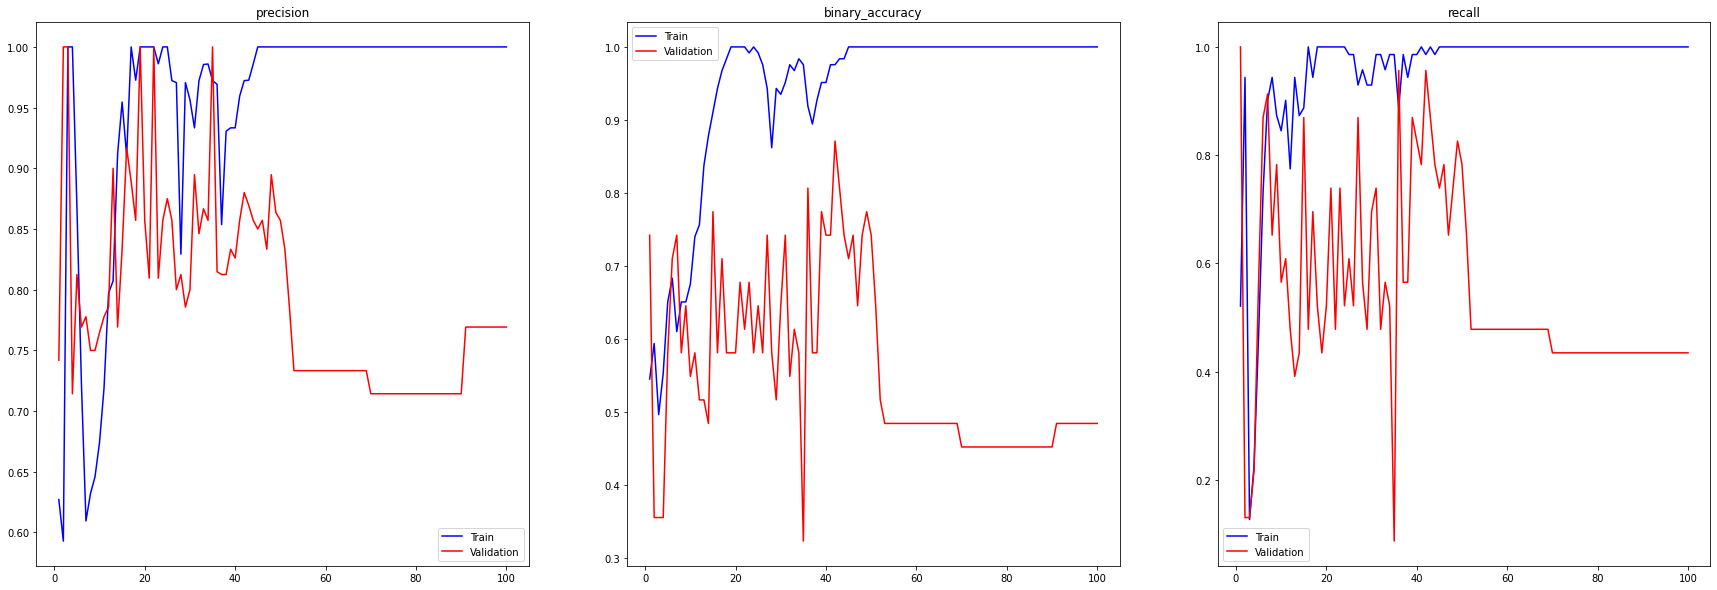

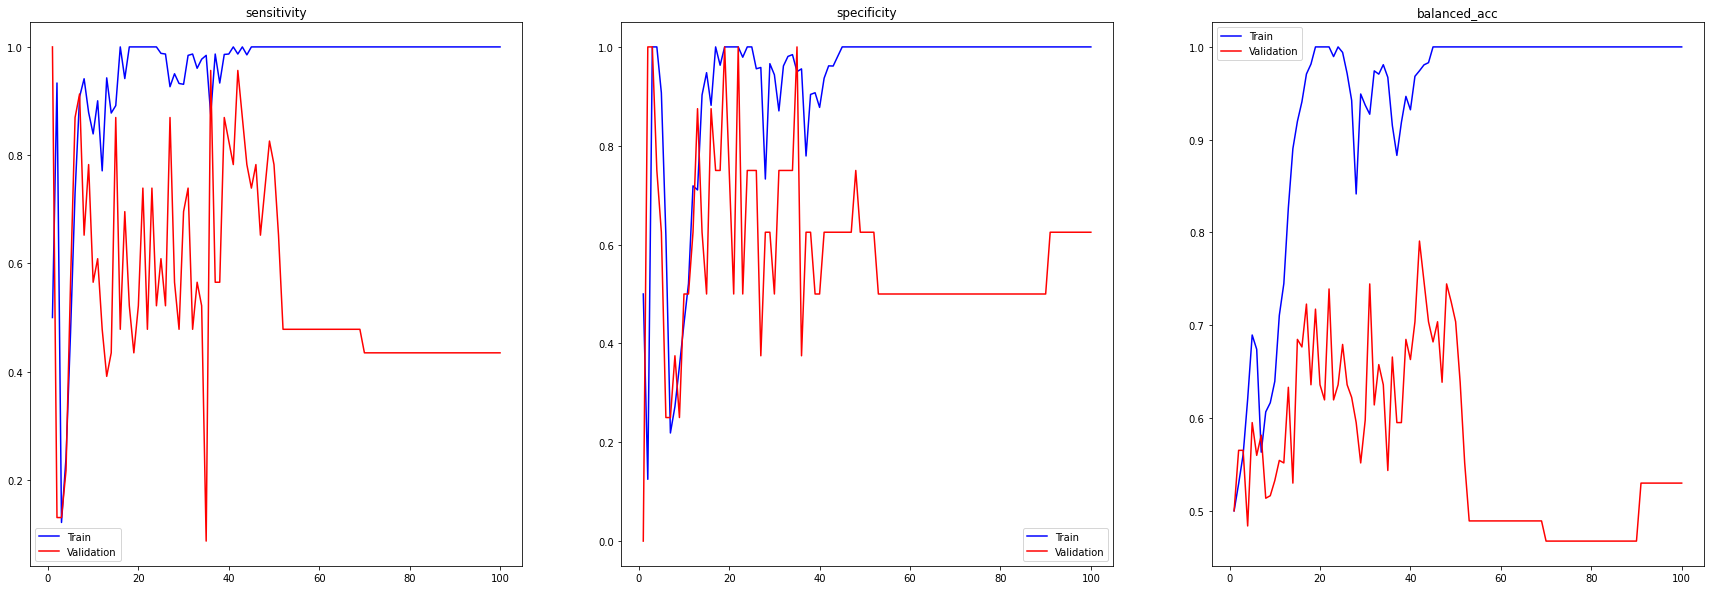

In [17]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['sensitivity', 'specificity', 'balanced_acc']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

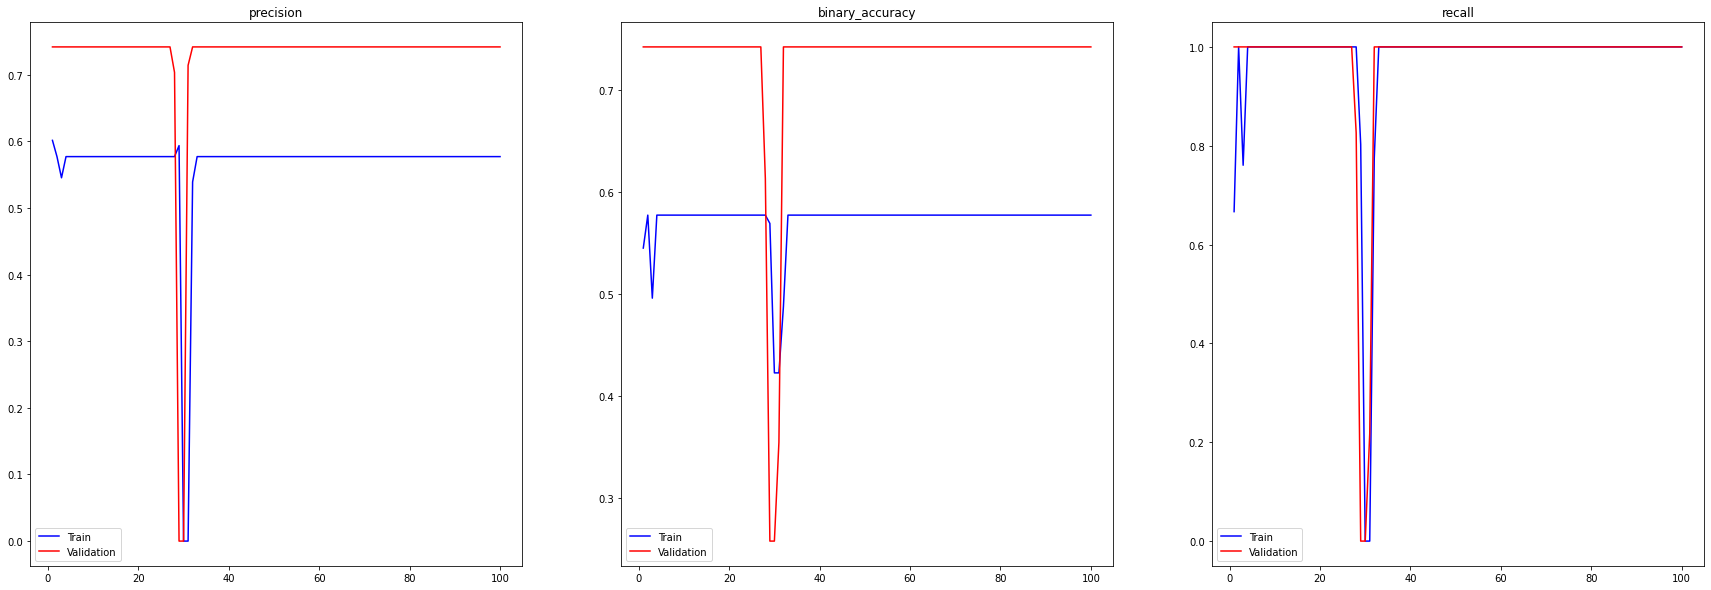

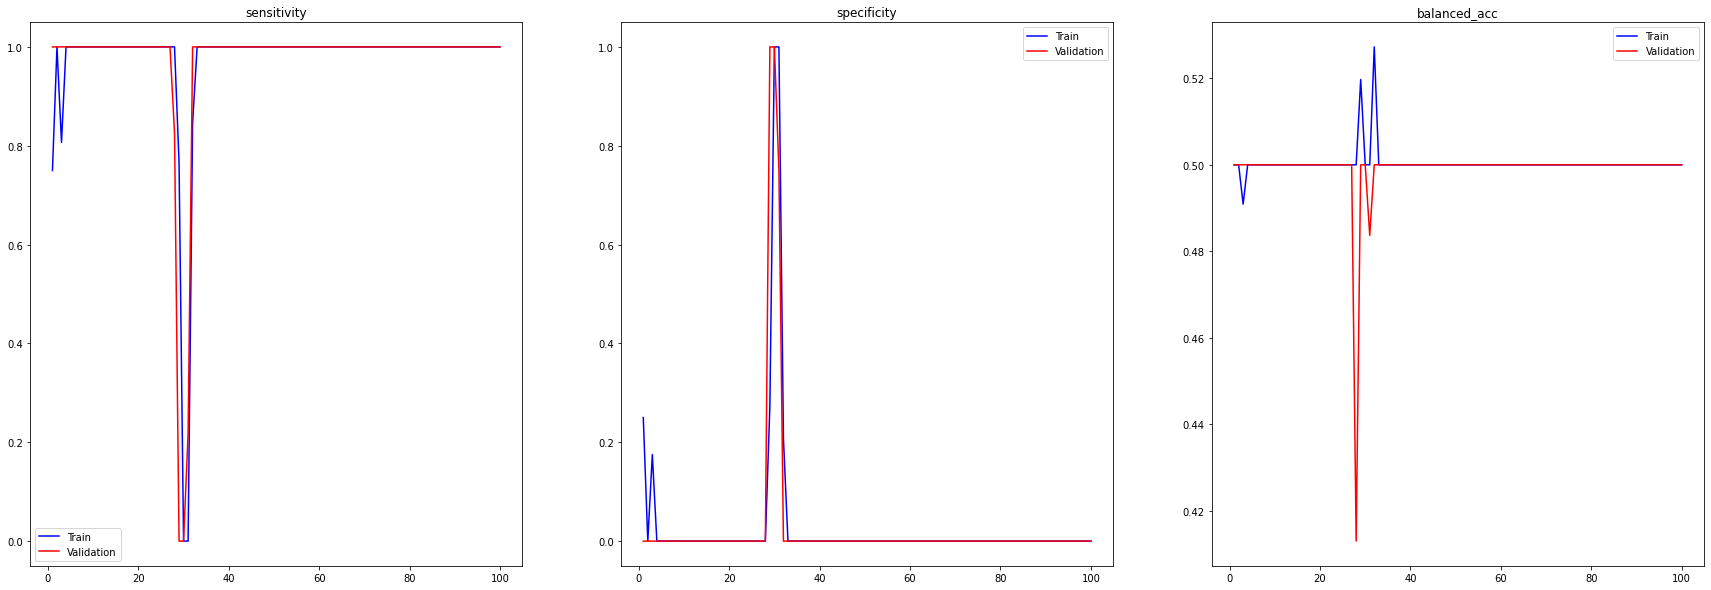

In [18]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

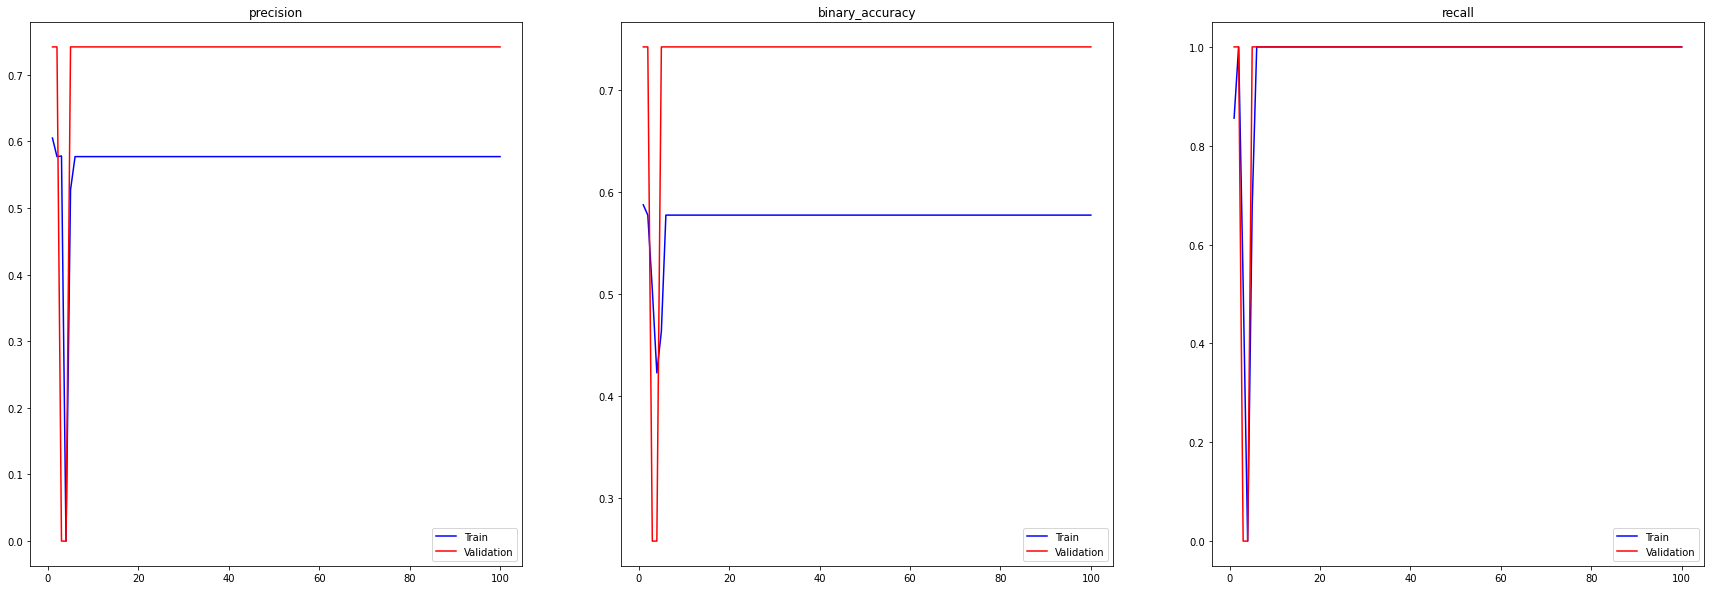

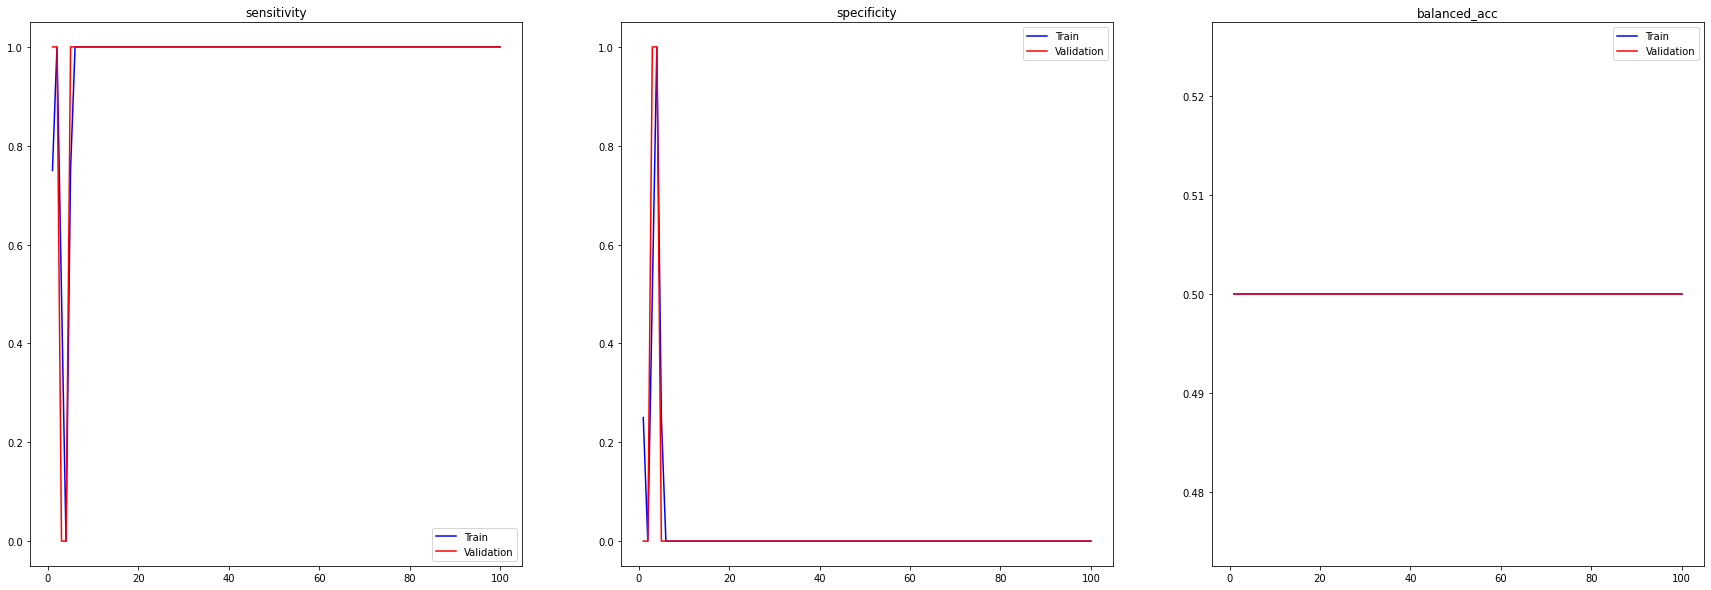

In [19]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [21]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [score[4] for score in scores], [score[5] for score in scores]
baccs = [score[6] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Sensitivity,Specificity,Balanced Accuracy
Le-Net 5,3.225811,0.750000,0.636364,0.6,0.404891,0.50463,0.45476
VGG-16,0.672570,0.606061,0.606061,1.0,1.000000,0.00000,0.50000
Lu-Net,0.673581,0.606061,0.606061,1.0,1.000000,0.00000,0.50000


In [22]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [9]:
# X_yes, X_no, classes = load_dataset()
# X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [10]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

X_train, y_train = data_augmentation(X_train, y_train, 20, imgs_trans)
X_test, y_test = data_augmentation(X_test, y_test, 20, imgs_trans)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# X_aug, y_aug = data_augmentation(X, classes, 20, imgs_trans)
# X_aug, y_aug = np.array(X_aug), np.array(y_aug)

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!



In [11]:
N, SIZE_H, SIZE_V = X_aug.shape
N_CLASSES = len(np.unique(y_aug))
print(f'X shape {X_aug.shape}')
print(f'Num classes: {N_CLASSES}')

X shape (4400, 224, 224)
Num classes: 2


In [12]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=sd, shuffle=True)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3080, 224, 224)
X_test shape: (1320, 224, 224)
y_train shape (3080,)
y_test shape: (1320,)


In [13]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
77/77 [==============================] - 117s 1s/step - loss: 29.6775 - precision: 0.6170 - binary_accuracy: 0.5950 - recall: 0.8683 - sensitivity: 0.8717 - specificity: 0.1818 - balanced_acc: 0.5268 - val_loss: 0.6302 - val_precision: 0.6290 - val_binary_accuracy: 0.6218 - val_recall: 0.9663 - val_sensitivity: 0.9618 - val_specificity: 0.0437 - val_balanced_acc: 0.5028
Epoch 2/100
77/77 [==============================] - 110s 1s/step - loss: 0.6165 - precision: 0.6224 - binary_accuracy: 0.6230 - recall: 0.9550 - sensitivity: 0.9553 - specificity: 0.1156 - balanced_acc: 0.5355 - val_loss: 0.5998 - val_precision: 0.6622 - val_binary_accuracy: 0.6510 - val_recall: 0.9041 - val_sensitivity: 0.9049 - val_specificity: 0.2529 - val_balanced_acc: 0.5789
Epoch 3/100
77/77 [==============================] - 110s 1s/step - loss: 0.5720 - precision: 0.6954 - binary_accuracy: 0.6794 - recall: 0.8347 - sensitivity: 0.8324 - specificity: 0.4502 - balanced_acc: 0.6413 - val_loss: 0.5947 -

In [14]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,29.677504,0.617001,0.594968,0.868280,0.871743,0.181816,0.526780,0.630212,0.629005,0.621753,0.966321,0.961785,0.043742,0.502763
1,0.616544,0.622427,0.622971,0.954973,0.955300,0.115642,0.535471,0.599797,0.662239,0.650974,0.904145,0.904891,0.252923,0.578907
2,0.571967,0.695409,0.679383,0.834677,0.832409,0.450169,0.641289,0.594657,0.726316,0.652597,0.715026,0.713124,0.556153,0.634638
3,0.531039,0.752224,0.718344,0.795699,0.796148,0.604554,0.700351,0.588395,0.748634,0.668831,0.709845,0.711449,0.608165,0.659807
4,0.469384,0.806667,0.769481,0.813172,0.810597,0.700688,0.755643,0.616786,0.747253,0.665584,0.704663,0.711979,0.613985,0.662982


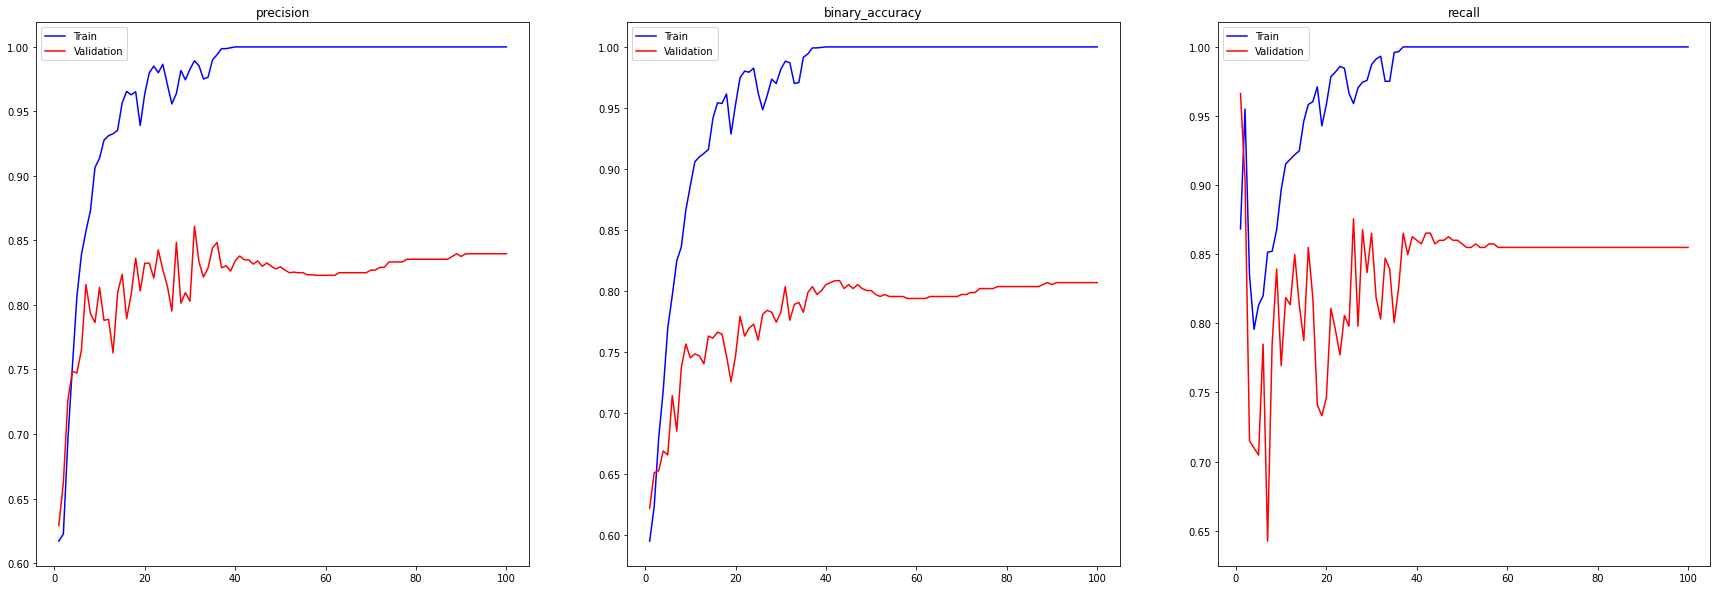

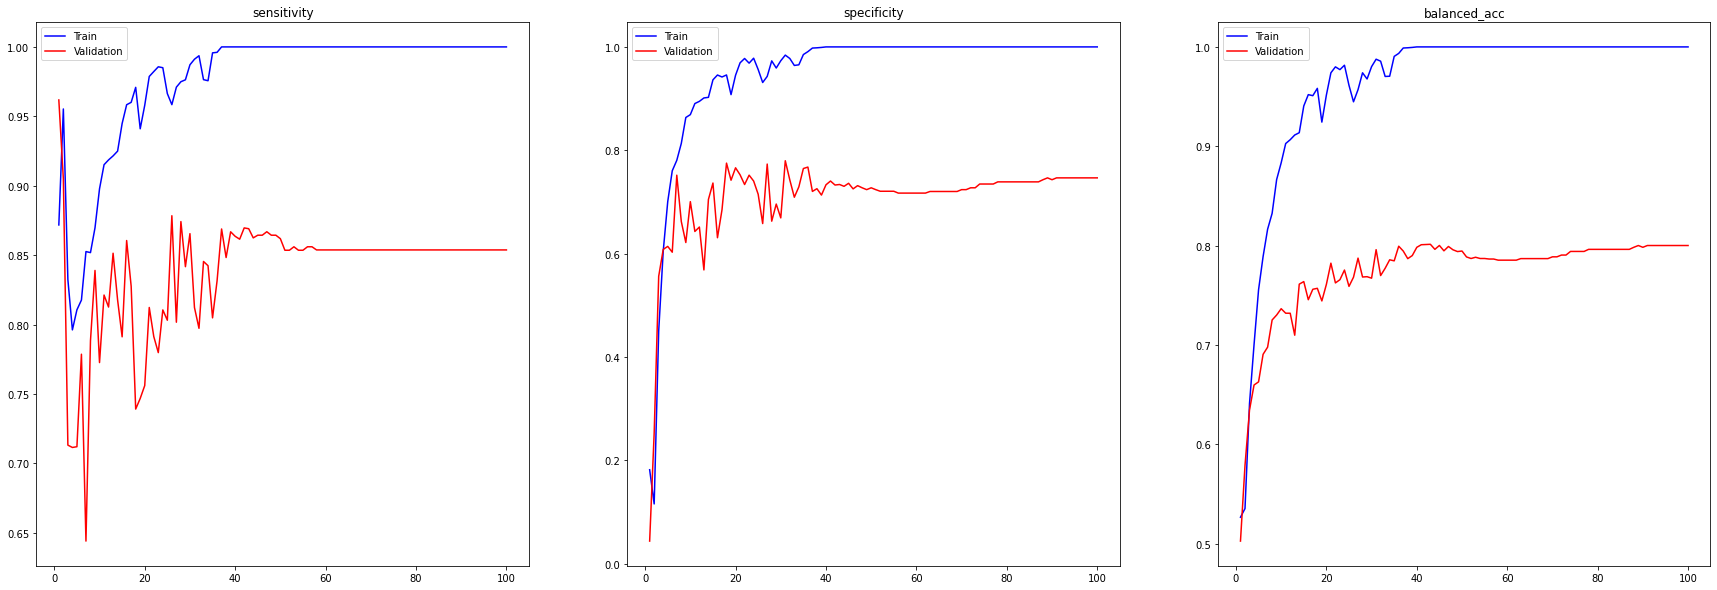

In [16]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['sensitivity', 'specificity', 'balanced_acc']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [17]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [score[4] for score in scores], [score[5] for score in scores]
baccs = [balanced_acc(sens, spec) for sens, spec in zip(sensitivities, specificities)]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
})
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')